Task 2: Loading Data for XGBoost...
Extracting LDA Features...
Training XGBoost...


D:\Python\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:50:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\Python\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:50:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\Python\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:50:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\Python\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:50:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\Python\Lib\site-packages\xgbo

XGBoost (LDA) 10-Fold CV Accuracy: 0.3910


D:\Python\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:50:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost Classification Report ---
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.35      0.43      0.38        68
Frontotemporal Dementia       0.57      0.51      0.54        59
     Lewy Body Dementia       0.53      0.42      0.47        64
    Parkinson's Disease       0.39      0.38      0.39        68
      Vascular Dementia       0.46      0.50      0.48        70

               accuracy                           0.45       329
              macro avg       0.46      0.45      0.45       329
           weighted avg       0.46      0.45      0.45       329



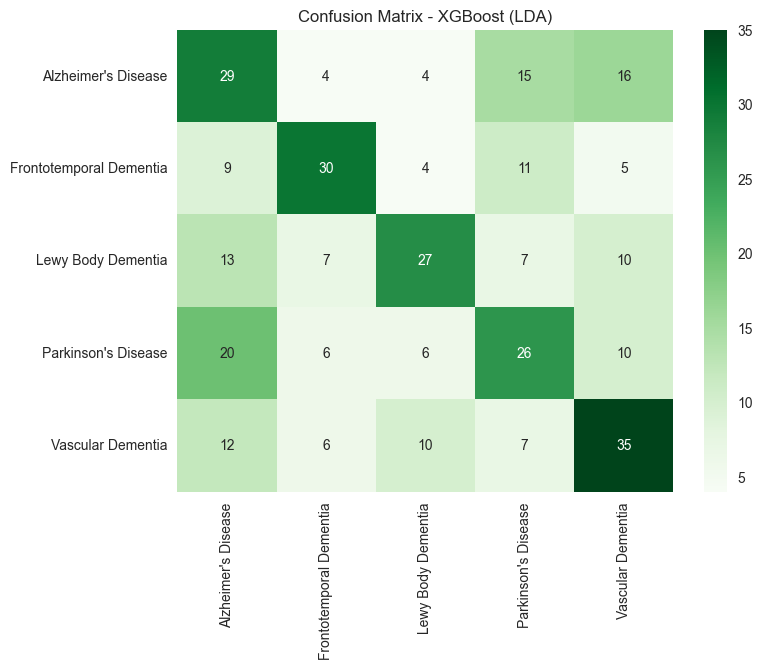

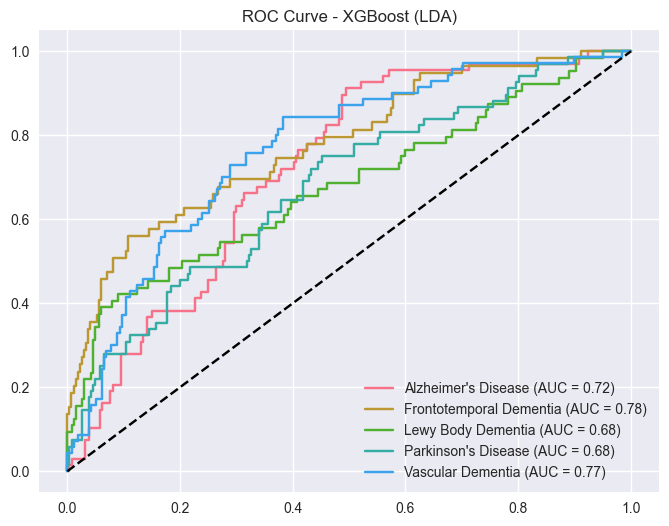

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

# 设置绘图风格
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ==========================================
# 1. 数据准备
# ==========================================
print("Task 2: Loading Data for XGBoost...")
df = pd.read_csv('cleaned_data.csv')
df['Cleaned_Content'] = df['Cleaned_Content'].fillna('')

# XGBoost 特殊处理: 标签必须编码为数字 (0, 1, 2...)
le = LabelEncoder()
df['Label_Encoded'] = le.fit_transform(df['Label'])
class_names = le.classes_

# 划分训练集和测试集
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['Cleaned_Content'], df['Label_Encoded'], test_size=0.2, random_state=42, stratify=df['Label_Encoded']
)

# ==========================================
# 2. 特征工程: LDA
# ==========================================
print("Extracting LDA Features...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tf_train = tf_vectorizer.fit_transform(X_train_raw)
tf_test = tf_vectorizer.transform(X_test_raw)

# 训练 LDA
lda = LatentDirichletAllocation(n_components=20, max_iter=10, learning_method='online', random_state=42, n_jobs=-1)
X_train_lda = lda.fit_transform(tf_train)
X_test_lda = lda.transform(tf_test)

# ==========================================
# 3. 模型训练: XGBoost
# ==========================================
print("Training XGBoost...")
# XGBoost 参数
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    objective='multi:softprob', # 多分类概率
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# 10折交叉验证
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X_train_lda, y_train, cv=cv, scoring='accuracy')

print(f"XGBoost (LDA) 10-Fold CV Accuracy: {cv_scores.mean():.4f}")

# 全量训练
xgb_model.fit(X_train_lda, y_train)

# ==========================================
# 4. 评估与可视化
# ==========================================
y_pred = xgb_model.predict(X_test_lda)
y_prob = xgb_model.predict_proba(X_test_lda)

print("\n--- XGBoost Classification Report ---")
print(classification_report(y_test, y_pred, target_names=class_names))

# 混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - XGBoost (LDA)')
plt.show()

# ROC 曲线
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - XGBoost (LDA)')
plt.legend()
plt.show()